<a href="https://colab.research.google.com/github/kikofers/Machine-Learning/blob/main/notebooks/HFST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Mājasdarbs: Galīgo automātu lietojums morfoloģijā.

In [5]:
!pip install hfst

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 MB 13.3 MB/s eta 0:00:00


In [6]:
import hfst
from IPython.display import Image

## Leksikona izveide
```
Multichar_Symbols
        +N      ! Noun tag
        +Sg     ! Singular
        +Pl     ! Plural
        +Nom
        +Gen
        +Dat
        +Acc
        +Loc

!Define root lexicon
LEXICON Root
  Nouns ; ! No input, no output

!Define noun lexicon
LEXICON Nouns
  kūk N4dekl ;
  paziņ N4dekl ;
  mašīn N4dekl ;

  kartupel N2dekl ;
  džemper N2dekl ;
  kām N2dekl;

  salāt N1dekl ;
  gald N1dekl ;
  zēn N1dekl ;


! Define 4th declension paradigm
LEXICON N4dekl
+N+Sg+Nom:^a  # ;
+N+Sg+Gen:^as # ;
+N+Sg+Dat:^ai # ;
+N+Sg+Acc:^u # ;
+N+Sg+Loc:^ā # ;
+N+Pl+Nom:^as  # ;
+N+Pl+Gen:^u  # ;
+N+Pl+Dat:^ām # ;
+N+Pl+Acc:^as # ;
+N+Pl+Loc:^ās # ;

! Define 2th declension paradigm
LEXICON N2dekl
+N+Sg+Nom:^is  #;
+N+Sg+Gen:^Ma  #;
+N+Sg+Dat:^im #;
+N+Sg+Acc:^i #;
+N+Sg+Loc:^ī #;
+N+Pl+Nom:^Mi  #;
+N+Pl+Gen:^Mu  #;
+N+Pl+Dat:^Miem #;
+N+Pl+Acc:^Mus #;
+N+Pl+Loc:^Mos #;

! Define 1th declension paradigm
LEXICON N1dekl
+N+Sg+Nom:^s  # ;
+N+Sg+Gen:^a # ;
+N+Sg+Dat:^am # ;
+N+Sg+Acc:^u # ;
+N+Sg+Loc:^ā # ;
+N+Pl+Nom:^i  # ;
+N+Pl+Gen:^u  # ;
+N+Pl+Dat:^iem # ;
+N+Pl+Acc:^us # ;
+N+Pl+Loc:^os # ;

```



In [9]:
# Leksikona augšuplāde no faila (pēctam ieliekam manis augšā nodefinēto leksikona saturu!).
!wget https://raw.githubusercontent.com/kikofers/Machine-Learning/refs/heads/main/notebooks/Latvian.lexc

--2025-05-15 17:45:09--  https://raw.githubusercontent.com/kikofers/Machine-Learning/refs/heads/main/notebooks/Latvian.lexc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1176 (1.1K) [text/plain]
Saving to: ‘Latvian.lexc’

Latvian.lexc        100%[===================>]   1.15K  --.-KB/s    in 0s      

2025-05-15 17:45:09 (70.6 MB/s) - ‘Latvian.lexc’ saved [1176/1176]



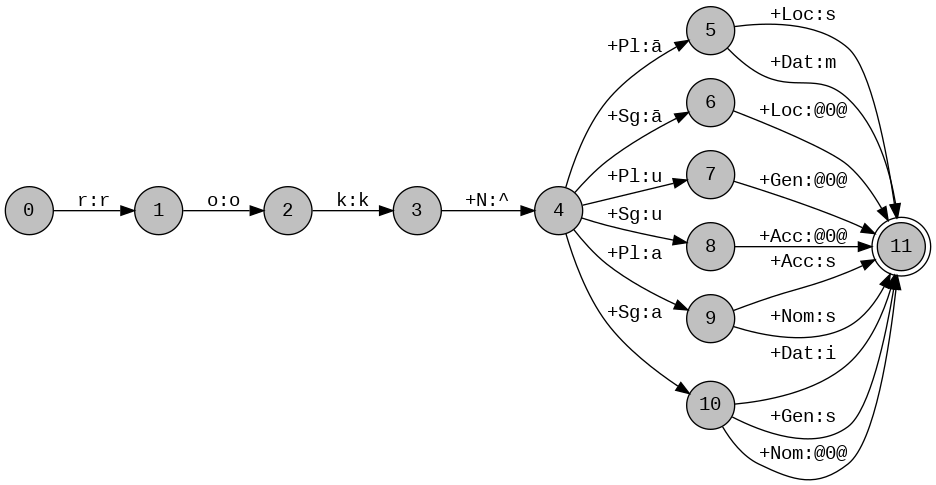

In [10]:
from hfst import compile_lexc_file
generator = hfst.compile_lexc_file('Latvian.lexc')
print(generator.lookup('kām+N+Sg+Loc'))

(('kām^ī@_EPSILON_SYMBOL_@', 0.0),)


## Transdjūseri: divlīmeņu morfoloģija


In [11]:
# Sintēze.
from hfst import HfstTransducer
analyzer = HfstTransducer(generator)
print(analyzer.lookup('kūk+N+Sg+Nom'))

(('kūk^a@_EPSILON_SYMBOL_@', 0.0),)


In [12]:
# Vārda analīze.
analyzer.invert()
analyzer.minimize()
print(analyzer.lookup('kūk^ā'))

(('kūk+N+Sg+Loc', 0.0),)


In [13]:
# Salīdzināšana.
analyzer.invert()
analyzer.minimize()
print(analyzer.compare(generator))

True


## FST kaskadēšana

In [14]:
from hfst import regex, HfstTransducer

### Iespraušana

In [15]:
InsertJ = hfst.regex('[..] -> j || [b | f | m | p | v] _ "^" M')
print(InsertJ.lookup("šķiv^Ma'"))

(("šķivj^Ma'", 0.0),)


### Aizstāšana

In [16]:
CReplacement = hfst.regex('l -> ļ ||  _ "^" M')
print(CReplacement.lookup("kartupel^Ma'"))

(("kartupeļ^Ma'", 0.0),)


### Izņēmumi

In [17]:
# Izņēmums vīriešu dzimtas 4. deklinācijas vārdam "paziņa".
Exceptions = hfst.regex('[[{paziņ} "+N" "+Sg" "+Dat" .x. {paziņam}] ]')
Exceptions = hfst.regex('a i-> a m || p a z i ņ "^"  _')
print(Exceptions.lookup("paziņ^ai"))

(('paziņ^am', 0.0),)


### Dzēšana

In [18]:
MCleanup = hfst.regex('M -> 0')
Cleanup = hfst.regex('"^" -> 0')
print(MCleanup.lookup("džemper^Ma'"))

(("džemper^@_EPSILON_SYMBOL_@a'", 0.0),)


## FST apvienošana

In [19]:
from hfst import compose

# Sintēze.
cascade = compose((generator, InsertJ, CReplacement, Exceptions, MCleanup, Cleanup))
print(cascade.lookup("kūk+N+Pl+Loc"))
print(cascade.lookup("mašīn+N+Sg+Dat"))

(('kūk@_EPSILON_SYMBOL_@ās', 0.0),)
(('mašīn@_EPSILON_SYMBOL_@ai', 0.0),)


In [20]:
# Noņemam epsilonu.
cascade.remove_epsilons()
print(cascade.lookup("kūk+N+Pl+Loc")[0][0].replace("@_EPSILON_SYMBOL_@", ""))

kūkās


In [21]:
# Analīze.
inv = hfst.HfstTransducer(cascade)
inv.invert()
inv.convert(hfst.ImplementationType.HFST_OL_TYPE)
print(inv.lookup("kūkās"))
print(inv.lookup("džemperos"))

(('kūk+N+Pl+Loc', 0.0),)
(('džemper+N+Pl+Loc', 0.0),)


## FST vizualizācija

In [22]:
import sys

def hfst2png(transducer, png_name):
    # Write the FST to a file using the att format
    f = open("a.att", "w", encoding="utf-8")
    transducer.minimize()
    transducer.write_att(f, False)

    # Convert the FST file to the dot format
    # dot format is used by graphviz library for graph visualization
    f = open("a.att", "r", encoding="utf-8")
    with open("graph.dot", "w", encoding="utf-8") as out_f:
        out_f.write('digraph G { rankdir="LR"\n')
        out_f.write('node [fontname="Tahoma",shape=circle,fontsize=14,fixedsize=true,fillcolor="grey",style=filled]\n')
        out_f.write('edge [fontname="FreeMono",fontsize=14]\n')
        for line in f.readlines():
            line = line.strip()
            row = line.split('\t')
            if len(row) >= 4:
                out_f.write('%s [label="%s"];\n' % (row[0], row[0]))
                out_f.write('%s -> %s [label="%s:%s"];\n' % (row[0], row[1], row[2], row[3]))
            elif len(row) == 1: # Final state
                out_f.write('%s [label="%s",shape=doublecircle];\n' % (row[0], row[0]))
        out_f.write('}')

    # Call graphviz dot function to generate a png file from dot file
    !dot -Tpng graph.dot > $png_name

Izdrukāšana

In [23]:
for noun in ["kūk", "paziņ", "mašīn", "kartupel", "džemper", "kām", "salāt", "gald", "zēn"]:
    for number in ["Sg", "Pl"]:
        for form in ["Nom", "Gen", "Dat", "Acc", "Loc"]:
            print(noun + "+N+" + number + "+" + form + " - " + cascade.lookup(noun + "+N+" + number + "+" + form)[0][0].replace("@_EPSILON_SYMBOL_@", ""))


kūk+N+Sg+Nom - kūka
kūk+N+Sg+Gen - kūkas
kūk+N+Sg+Dat - kūkai
kūk+N+Sg+Acc - kūku
kūk+N+Sg+Loc - kūkā
kūk+N+Pl+Nom - kūkas
kūk+N+Pl+Gen - kūku
kūk+N+Pl+Dat - kūkām
kūk+N+Pl+Acc - kūkas
kūk+N+Pl+Loc - kūkās
paziņ+N+Sg+Nom - paziņa
paziņ+N+Sg+Gen - paziņas
paziņ+N+Sg+Dat - paziņam
paziņ+N+Sg+Acc - paziņu
paziņ+N+Sg+Loc - paziņā
paziņ+N+Pl+Nom - paziņas
paziņ+N+Pl+Gen - paziņu
paziņ+N+Pl+Dat - paziņām
paziņ+N+Pl+Acc - paziņas
paziņ+N+Pl+Loc - paziņās
mašīn+N+Sg+Nom - mašīna
mašīn+N+Sg+Gen - mašīnas
mašīn+N+Sg+Dat - mašīnai
mašīn+N+Sg+Acc - mašīnu
mašīn+N+Sg+Loc - mašīnā
mašīn+N+Pl+Nom - mašīnas
mašīn+N+Pl+Gen - mašīnu
mašīn+N+Pl+Dat - mašīnām
mašīn+N+Pl+Acc - mašīnas
mašīn+N+Pl+Loc - mašīnās
kartupel+N+Sg+Nom - kartupelis
kartupel+N+Sg+Gen - kartupeļa
kartupel+N+Sg+Dat - kartupelim
kartupel+N+Sg+Acc - kartupeli
kartupel+N+Sg+Loc - kartupelī
kartupel+N+Pl+Nom - kartupeļi
kartupel+N+Pl+Gen - kartupeļu
kartupel+N+Pl+Dat - kartupeļiem
kartupel+N+Pl+Acc - kartupeļus
kartupel+N+Pl+Loc - kartupe